# Neural Network 201
In this example, we will walk through two-input single output neural network model. We will train this model to predict used cars' prices based on two features: age and mileage.

The following contents will be covered:
1. Preprocess the data.
2. Construct multi-input linear model.
3. Vector and matrix operations.
4. Rectified linear unit (ReLU) activation.


## Load Raw Data
Data is from [Used Car Dataset](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data). Data is prepocessed and shuffled. N/As and outliers were taken out. 90% are used for training the model. We'll use the rest 10% samples to evaluate and test the model. 

First, let's load the data as numpy arrays.

In [1]:
import numpy as np
age_train = np.load('age_train.npy')
mileage_train = np.load('mileage_train.npy')
price_train = np.load('price_train.npy')
age_test = np.load('age_test.npy')
mileage_test = np.load('mileage_test.npy')
price_test = np.load('price_test.npy')
print(f"age_train shape: {age_train.shape}")
print(f"mileage_train shape: {mileage_train.shape}")
print(f"price_train shape: {age_train.shape}")
print(f"age_test shape: {age_test.shape}")
print(f"mileage_test shape: {mileage_test.shape}")
print(f"price_test shape: {age_test.shape}")


age_train shape: (268577,)
mileage_train shape: (268577,)
price_train shape: (268577,)
age_test shape: (29842,)
mileage_test shape: (29842,)
price_test shape: (29842,)


## Visualize the Data
Use [matplotlib](https://matplotlib.org/). **Note**: `matplotlib` will auto scale the figure to better fill the space.

[Text(0.5, 0, 'Mileage (miles)'), Text(0, 0.5, 'Price ($)')]

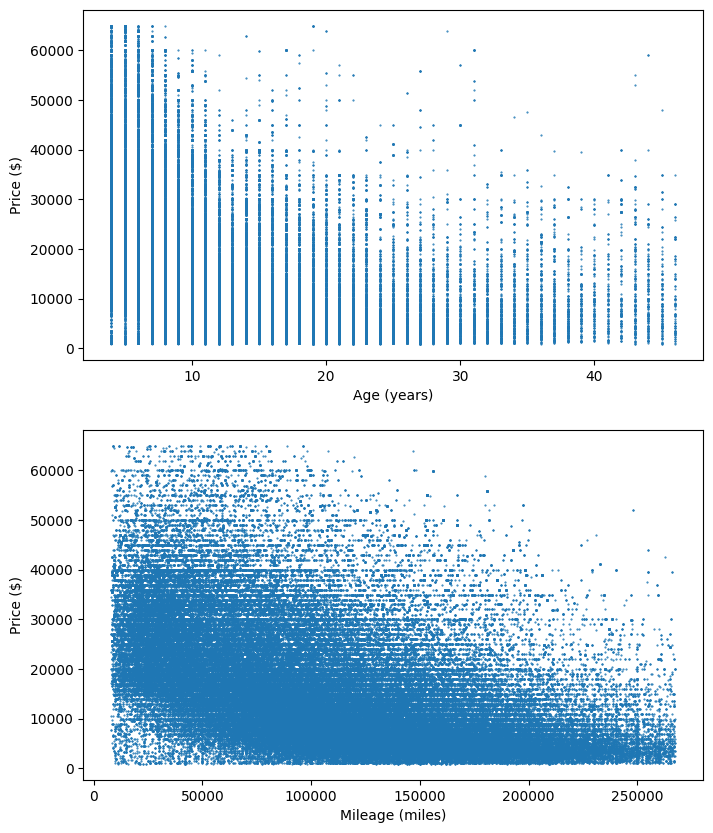

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(age_train, price_train, '.', markersize=1)
axs[0].set(xlabel='Age (years)', ylabel='Price ($)')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(mileage_train, price_train, '.', markersize=1)
axs[1].set(xlabel='Mileage (miles)', ylabel='Price ($)')


Visualize raw data in 3D space

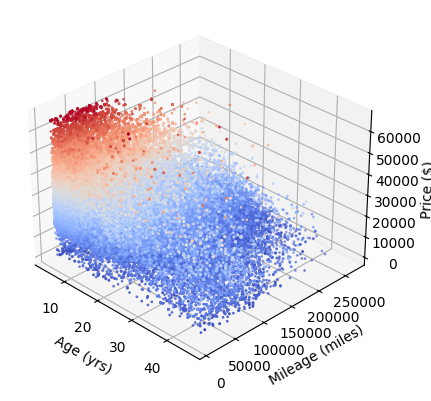

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the data
scatter = ax.scatter3D(age_train, mileage_train, price_train, s=np.ones(price_train.size), c=price_train, cmap='coolwarm') 

ax.set_xlabel('Age (yrs)')
ax.set_ylabel('Mileage (miles)')
ax.set_zlabel('Price ($)')

ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle

# colorbar = fig.colorbar(scatter, ax=ax)


## Pre-process the Data
1. Rescale `age`, `mileage` and `price` arrays to avoid large parameters in model. 
2. Stack the rescaled `age` and `mileage` arrays to form a feature matrix, or a 2d-array with shape (M, 2). 
3. Reshape rescaled `price` array to a column vector, or a 2d-array with shape (M, 1).
> M represents number of samples.

(268577, 2) (268577, 1) (29842, 2) (29842, 1)


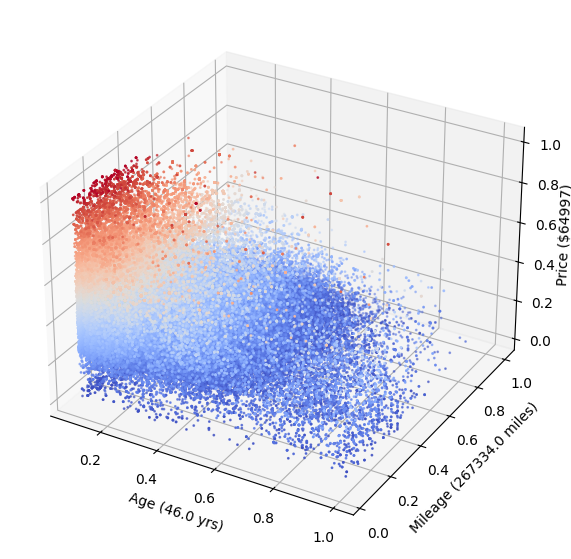

In [4]:
# Rescale
# age_train_rescale = age_train / 10
# mileage_train_rescale = mileage_train / 1e4
# price_train_rescale = price_train / 1e4
# age_test_rescale = age_test / 10
# mileage_test_rescale = mileage_test / 1e4
# price_test_rescale = price_test / 1e4
age_train_rescale = age_train / age_train.max()
mileage_train_rescale = mileage_train / mileage_train.max()
price_train_rescale = price_train / price_train.max()
age_test_rescale = age_test / age_train.max()
mileage_test_rescale = mileage_test / mileage_train.max()
price_test_rescale = price_test / price_train.max()

# Stack features
X_train = np.stack((age_train_rescale, mileage_train_rescale), axis=1)
X_test = np.stack((age_test_rescale, mileage_test_rescale), axis=1)
# Reshape labels
y_train = price_train_rescale.reshape(-1, 1)
y_test = price_test_rescale.reshape(-1, 1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)  # for debug

fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Plot the data
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train.squeeze(), s=np.ones(y_train.size), c=y_train.squeeze(), cmap='coolwarm') 

ax.set_xlabel(f'Age ({age_train.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_train.max()} miles)')
ax.set_zlabel(f'Price (${price_train.max()})')
ax.zaxis.labelpad = -0.5 # display z label

# ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle


## Create an Initial Model
Create a linear model: $\hat{y}=w_1x_1 + w_2x_2 + b$. Initialize three parameters, $w_1$, $w_2$ and $b$ to small values (close to 0).

$\hat{\mathbf{y}} = \mathbf{X} \cdot \mathbf{w}^T + \mathbf{b}$

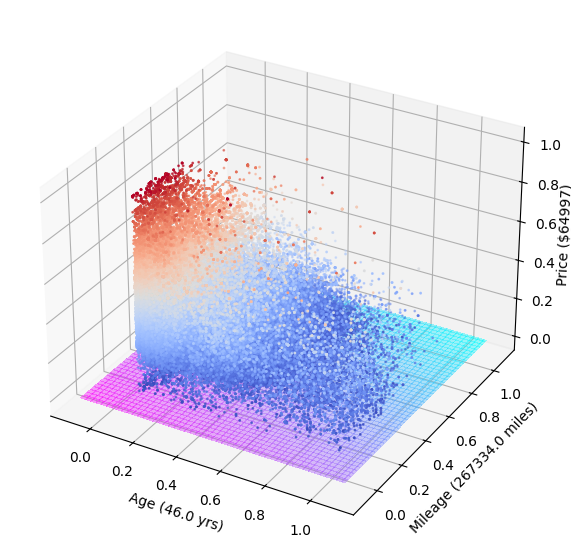

In [5]:
# Define model function
def linear(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (samples #, features #)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (dependent variables), 2d-array with shape (# samples, 1)
    """
    output = input @ weight.T + bias
    return output

# Initialize model parameters: w1, w2, b
w_guess = np.random.normal(0, 1e-4, (1, 2)) 
b_guess = np.random.normal(0, 1e-4)
y_pred = linear(X_train, w_guess, b_guess)

fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Define the grid of points for the plane
x_grid = np.linspace(-0.1, 1.1, 100)
y_grid = np.linspace(-0.1, 1.1, 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
z_mesh = w_guess[0, 0] * x_mesh + w_guess[0, 1] * y_mesh + b_guess
# Plot the data
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train.squeeze(), s=np.ones(y_train.size), c=y_train.squeeze(), cmap='coolwarm') 
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='cool', antialiased=False, alpha=0.4)

ax.set_xlabel(f'Age ({age_train.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_train.max()} miles)')
ax.set_zlabel(f'Price (${price_train.max()})')
ax.zaxis.labelpad = -0.5 # display z label

# ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle


## Create Loss Function
Use Mean Square Error function to evaluate how bad the model was.

In [6]:
def mse_loss(pred, label):
    """ Mean Square Error function
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        label: column vector of ground truths, 2d-array with shape (# samples, 1)
    Returns:
        loss_value: scalar
    """
    loss_value = np.mean(0.5 * (pred - label) ** 2)
    return loss_value

# Evaluate initial model
loss = mse_loss(pred=linear(X_train, w_guess, b_guess), label=y_train)
print(f"mse loss: {loss}")

mse loss: 0.0513553586413941


## Gradient Descent Optimization

In [7]:
# Define gradient computation function
def grad(input, pred, label):
    """ Gradient function
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        input: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dw = 1 / label.shape[0] * ((pred - label).T @ input)  # dL/dw
    db = (pred - label).mean()  # dL/db
    
    return dw, db



Gradient Descent Iterations

initial parameters: w = [[-3.13183216e-05 -1.64117152e-04]], b = -2.059138104735128e-05
loss @ 1 iteration: 0.051375907517018
loss @ 2 iteration: 0.049838283785620184
loss @ 3 iteration: 0.04837363318785694
loss @ 4 iteration: 0.046978462829039384
loss @ 5 iteration: 0.045649447052589415
loss @ 6 iteration: 0.04438341943267871
loss @ 7 iteration: 0.043177365150260105
loss @ 8 iteration: 0.04202841373413486
loss @ 9 iteration: 0.04093383214957782
loss @ 10 iteration: 0.03989101821787919
loss @ 11 iteration: 0.03889749435095879
loss @ 12 iteration: 0.037950901585967305
loss @ 13 iteration: 0.03704899390551067
loss @ 14 iteration: 0.036189632829822266
loss @ 15 iteration: 0.03537078226786227
loss @ 16 iteration: 0.03459050361494615
loss @ 17 iteration: 0.03384695108509885
loss @ 18 iteration: 0.033138367266896236
loss @ 19 iteration: 0.03246307889209249
loss @ 20 iteration: 0.03181949280684608
loss @ 21 iteration: 0.03120609213584324
loss @ 22 iteration: 0.030621432630083517
loss @ 23 ite

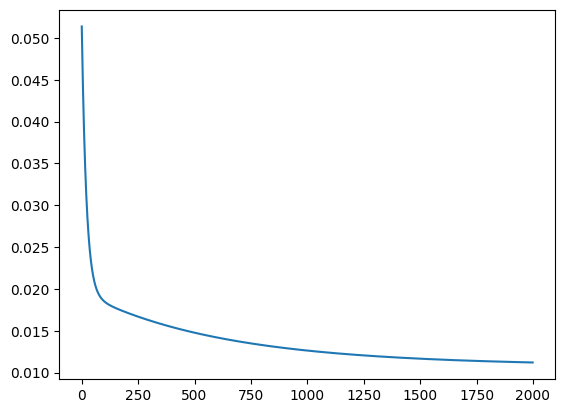

In [8]:
w = np.random.normal(0, 1e-4, (1, 2)) 
b = np.random.normal(0, 1e-4)
print(f"initial parameters: w = {w}, b = {b}")
# Gradient descent optimization
num_iters = 2000
learning_rate = 0.02
losses = []
for i in range(num_iters):
    y_pred = linear(X_train, w, b)
    dw, db = grad(X_train, y_pred, y_train)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    losses.append(loss)
print(f"final parameters: w = {w}, b = {b}")

# Observe the loss change
plt.plot(losses)

## Assess Model on Training Data
Now, we can use the updated model with **updated** $w_1$, $w_2$ and $b$ to predict car prices.

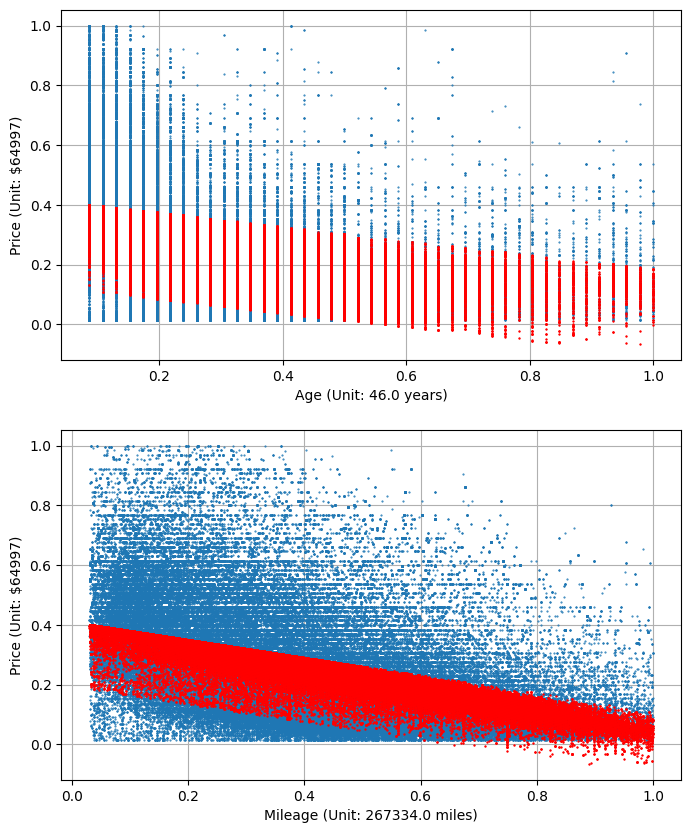

In [9]:
# Visualize model on training data
fig, axs = plt.subplots(2,1)  # Initialize figures in 2 rows, 1 column
fig.set_figwidth(8)  # set figure size
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)  # plot in the first figure
axs[0].plot(X_train[:, 0], y_train, '.', markersize=1)  # draw blue dots
axs[0].plot(X_train[:, 0], y_pred, 'r+', markersize=2)  # draw red '+' markers
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')  # label axes
axs[0].grid()
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_train[:, 1], y_train, '.', markersize=1)
axs[1].plot(X_train[:, 1], y_pred, 'r+', markersize=2)
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1].grid()

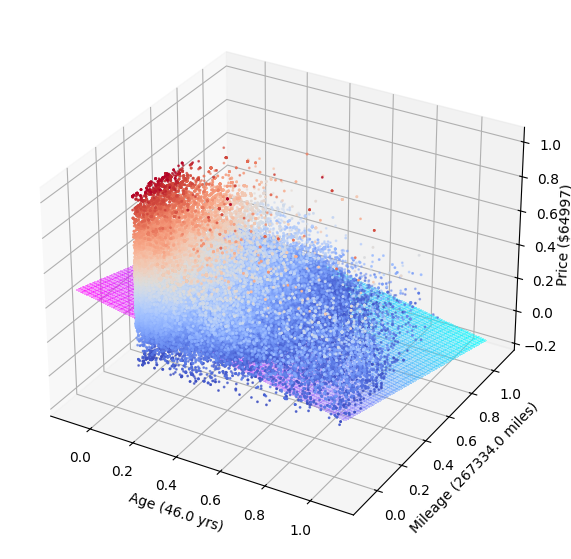

In [10]:
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Define the grid of points for the plane
z_mesh = w[0, 0] * x_mesh + w[0, 1] * y_mesh + b
# Plot the data
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train.squeeze(), s=np.ones(y_train.size), c=y_train.squeeze(), cmap='coolwarm') 
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='cool', linewidth=0, antialiased=False, alpha=0.4)

ax.set_xlabel(f'Age ({age_train.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_train.max()} miles)')
ax.set_zlabel(f'Price (${price_train.max()})')
ax.zaxis.labelpad = -0.5 # display z label

# ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle


### Assess Model on Test Data

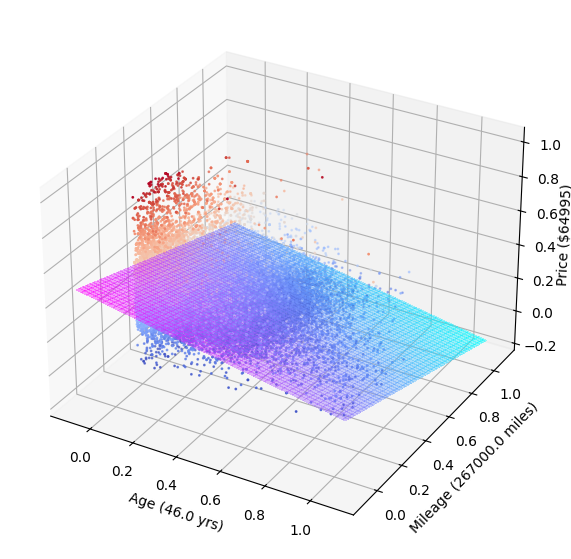

In [11]:
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Define the grid of points for the plane
z_mesh = w[0, 0] * x_mesh + w[0, 1] * y_mesh + b
# Plot the data
ax.scatter3D(X_test[:, 0], X_test[:, 1], y_test.squeeze(), s=np.ones(y_test.size), c=y_test.squeeze(), cmap='coolwarm') 
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='cool', linewidth=0, antialiased=False, alpha=0.4)

ax.set_xlabel(f'Age ({age_test.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_test.max()} miles)')
ax.set_zlabel(f'Price (${price_test.max()})')
ax.zaxis.labelpad = -0.5 # display z label

# ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle

## Sigmoid Activation

initial parameters: w = [[-4.96529937e-05 -1.82055593e-04]], b = 3.476881198944955e-05
loss @ 1 iteration: 0.045096965677856864
loss @ 2 iteration: 0.04495908960354513
loss @ 3 iteration: 0.04482183727960745
loss @ 4 iteration: 0.04468520661994551
loss @ 5 iteration: 0.04454919553313761
loss @ 6 iteration: 0.04441380192264335
loss @ 7 iteration: 0.04427902368700638
loss @ 8 iteration: 0.04414485872005492
loss @ 9 iteration: 0.04401130491110015
loss @ 10 iteration: 0.04387836014513249
loss @ 11 iteration: 0.04374602230301596
loss @ 12 iteration: 0.04361428926168004
loss @ 13 iteration: 0.04348315889430973
loss @ 14 iteration: 0.04335262907053343
loss @ 15 iteration: 0.043222697656608654
loss @ 16 iteration: 0.043093362515605575
loss @ 17 iteration: 0.04296462150758869
loss @ 18 iteration: 0.042836472489796204
loss @ 19 iteration: 0.04270891331681733
loss @ 20 iteration: 0.04258194184076758
loss @ 21 iteration: 0.04245555591146196
loss @ 22 iteration: 0.042329753376585975
loss @ 23 itera

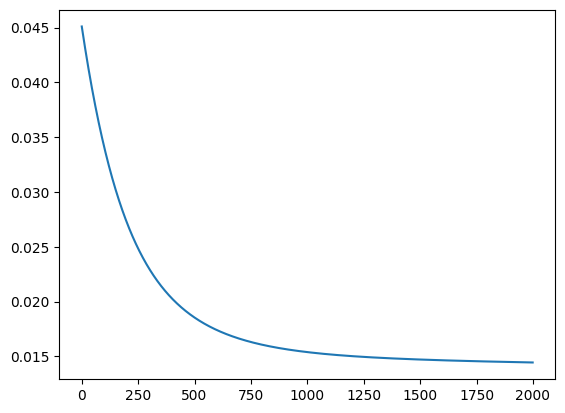

In [12]:
# Define ReLU function
def sigmoid(x):
    """ Sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    y = 1 / (1 + np.exp(-x))
    return y

# Define derivatives of ReLU function
def d_sigmoid(x):
    """ Derivative of sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        dydx: dependent variable, could be an arrary of any shape or a scalar.
    """
    dydx = sigmoid(x) * (1 - sigmoid(x))
    return dydx

# Redefine forward pass. Intermediate result, Z, needs to be tracked 
def forward(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (# samples, # features)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (sigmoid activated outcomes), 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
    """
    Z = linear(input, weight, bias)
    output = sigmoid(Z)
    return output, Z

# Redefine gradient function. An exatra step to calculate dL/dZ will be added. 
def grad(input, prediction, target, Z):
    """ Gradient function with sigmoid activation
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
        feature: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dZ = (prediction - target) * d_sigmoid(Z)
    dw = 1 / target.shape[0] * np.dot(dZ.T, input)
    db = dZ.mean()
    
    return dw, db

# Optimization with ReLU activation
w = np.random.normal(0, 1e-4, (1, 2)) 
b = np.random.normal(0, 1e-4)
print(f"initial parameters: w = {w}, b = {b}")
num_iters = 2000
learning_rate = 0.03
losses = []
for i in range(num_iters):
    y_pred, Z = forward(X_train, w, b)
    dw, db = grad(X_train, y_pred, y_train, Z)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    # print(f"w = {w}, b = {b}")
    losses.append(loss)
print(f"final parameters: w = {w}, b = {b}")

# Observe loss values
plt.plot(losses)

## Test Sigmoid Activated Model

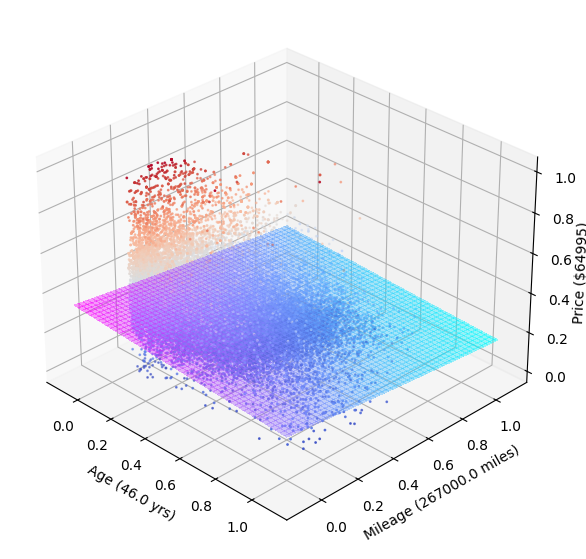

In [15]:
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Define the grid of points for the plane
z_mesh = sigmoid(w[0, 0] * x_mesh + w[0, 1] * y_mesh + b)
# Plot the data
ax.scatter3D(X_test[:, 0], X_test[:, 1], y_test.squeeze(), s=np.ones(y_test.size), c=y_test.squeeze(), cmap='coolwarm') 
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='cool', linewidth=0, antialiased=False, alpha=0.4)

ax.set_xlabel(f'Age ({age_test.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_test.max()} miles)')
ax.set_zlabel(f'Price (${price_test.max()})')
ax.zaxis.labelpad = -0.5 # display z label

ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle

Featurewise assessing

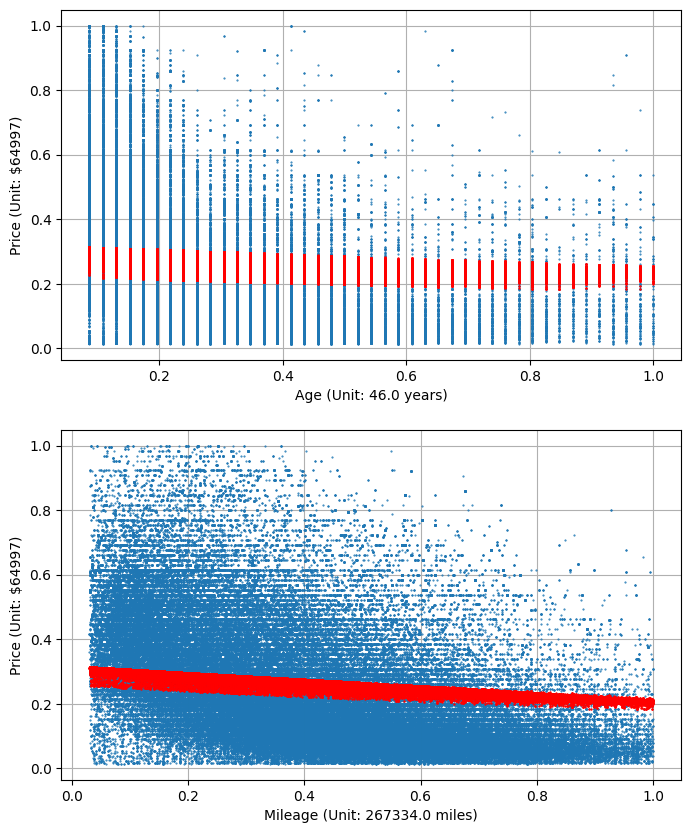

In [16]:
# Visualize model on training data
fig, axs = plt.subplots(2,1)  # Initialize figures in 2 rows, 1 column
fig.set_figwidth(8)  # set figure size
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)  # plot in the first figure
axs[0].plot(X_train[:, 0], y_train, '.', markersize=1)  # draw blue dots
axs[0].plot(X_train[:, 0], y_pred, 'r+', markersize=2)  # draw red '+' markers
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')  # label axes
axs[0].grid()
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_train[:, 1], y_train, '.', markersize=1)
axs[1].plot(X_train[:, 1], y_pred, 'r+', markersize=2)
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1].grid()

## ReLU Activation
Negative car price does not make sense. The output needs to be regulated to only output non-negative value.

In [ ]:
# Define ReLU function
def relu(x):
    """ ReLU function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    # y = x.copy()
    y = x
    y[x<=0] = 0
    return y

# Define derivatives of ReLU function
def d_relu(x):
    """ Derivative of ReLU function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        dydx: dependent variable, could be an arrary of any shape or a scalar.
    """
    dydx = np.zeros_like(x)
    dydx[x>0] = 1
    return dydx

# Redefine forward pass. Intermediate result, Z, needs to be tracked 
def forward(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (# samples, # features)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (sigmoid activated outcomes), 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
    """
    Z = np.dot(input, weight.T) + bias
    output = relu(Z)
    return output, Z

# Redefine gradient function. An exatra step to calculate dL/dZ will be added. 
def grad(prediction, target, Z, input):
    """ Gradient function with sigmoid activation
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
        feature: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dZ = (prediction - target) * d_relu(Z)
    dw = 1 / target.shape[0] * np.dot(dZ.T, input)
    db = dZ.mean()
    
    return dw, db

# Optimization with ReLU activation
w = np.zeros((1, 2)) + np.random.normal(0, 1e-4, (1, 2)) 
b = 0 + np.random.normal(0, 1e-4)
num_iters = 2000
learning_rate = 0.02
losses = []
for i in range(num_iters):
    y_pred, Z = forward(X_train, w, b)
    dw, db = grad(y_pred, y_train, Z, X_train)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    # print(f"w = {w}, b = {b}")
    losses.append(loss)
print(f"updated w={w}, b={b}")
print(f"Model's mse on test data: {mse_loss(forward(X_test, w, b), y_test)}")

# Observe loss values
plt.plot(losses)

## Visualize ReLU Activated Model

In [ ]:
y_test_pred, _ = forward(X_test, w, b)
print(f"Model's mse on test data: {mse_loss(y_test_pred, y_test)}")

# Visualize model on two dimensions
y_test_pred, _ = forward(X_test, w, b)
fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(X_test[:, 0], y_test, 'b.')
axs[0].plot(X_test[:, 0], y_test_pred, 'r+')
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_test[:, 1], y_test, 'b.')
axs[1].plot(X_test[:, 1], y_test_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

## 